```{autolink-concat}
```

::::{margin}
:::{card} Investigation of acceptance matrix with Dalitz-plot decomposition
TR-035
^^^
We investigate how to compute the acceptance matrix for a three-body decay with a spinful final state ($J/\psi \to \bar{p} K^0_S \Sigma^+$). The acceptance matrix then becomes a complex-valued matrix.
:::
::::

# DPD acceptance matrix

In [28]:
import itertools
from itertools import product
import logging
import re
import warnings
from collections.abc import Iterable

import attrs
import graphviz
import jax.numpy as jnp
import numpy as np
import qrules
import sympy as sp
from ampform.dynamics.form_factor import FormFactor
from ampform.kinematics.lorentz import (
    Energy,
    EuclideanNorm,
    FourMomentumSymbol,
    InvariantMass,
    ThreeMomentum,
)
from ampform.sympy import PoolSum
from ampform.sympy._decorator import unevaluated
from ampform_dpd import AmplitudeModel, DalitzPlotDecompositionBuilder
from ampform_dpd.adapter.qrules import normalize_state_ids, to_three_body_decay
from ampform_dpd.decay import IsobarNode, Particle, State, ThreeBodyDecayChain
from ampform_dpd.dynamics import RelativisticBreitWigner
from ampform_dpd.io import cached, simplify_latex_rendering
from IPython.display import HTML, display
from tensorwaves.data.phasespace import TFPhaseSpaceGenerator
from tensorwaves.data.rng import TFUniformRealNumberGenerator
from tensorwaves.data.transform import SympyDataTransformer
from tensorwaves.interface import DataSample, ParametrizedFunction

logging.getLogger().setLevel(logging.ERROR)
np.set_printoptions(linewidth=120)
simplify_latex_rendering()
warnings.simplefilter("ignore", category=RuntimeWarning)

In [29]:
display(HTML("<style>.container { width:100% !important; }</style>"))


To speed up the fit the part of the negative log likelihood (NLL) function representing the normalization computed over the  Monte-Carlo phsp can be pre-computed. Note that this method can only be applied in the _specific case that masses and widths are fixed_ as the normalization depends on these parameters.

Statistically this approach can be derived as follows:
Given total sample $\vec{x}$ consisting of _N_ independent observations of a set the $n$ quantities $x$ depending the likelihood function can be written as the product of the (Probability Density Functions) PDFs $f$ of each single observation:

$$L(\vec{x} ; \vec{\theta})=\prod_{\mathfrak{i}=1}^N f\left(x_i ; \vec{\theta}\right)$$

$\vec{\theta}$ represents the set of $m$ unknown parameters the chosen PDF depends on.
In the case of the this amplitude analysis the PDFs are the normalized intensity functions for each partial wave:

$$f(x_i ; \vec{\theta})= \frac{I(x_i ; \vec{\theta})}{\int I(\vec{x} ; \vec{\theta}) d\vec{x}}$$ 

 The $x_i$ represent the selected events containing the information about the Mandelstam variables and the decay and production angles. With the expression $f$ the NLL function is given as:

$$
NLL(x_i ; \vec{\theta})=-\sum^n_{i=1} \log \left(\frac{I(x_i ; \vec{\theta})}{\int I(\vec{x} ; \vec{\theta}) d\vec{x}}\right) = \underbrace{-\sum^n_{i=1} \log(I(x_i ; \vec{\theta}))}_{\mathrm{Data}} + n\cdot \log\left(\int I(\vec{x} ; \vec{\theta}) d\vec{x} \right)
$$

Since the second term integrates over all phase-space points, it is independent of \( x_i \) and can be approximated using Monte Carlo integration:

$$
\int I(\vec{x} \,; \vec{\theta}) \, d\vec{x} = 
c^{\dagger} \cdot \frac{1}{N_{\mathrm{MC}}} \sum_{j=1}^{N_{\mathrm{MC}}} I(\vec{x}_j^{\mathrm{MC}} \,; \vec{\theta}) \cdot c 
\cdot \left( \int d\vec{x} \right)
$$

The term $\frac{1}{N_{\mathrm{MC}}} \sum_{j=1}^{N_{\mathrm{MC}}} I(\vec{x}_j^{\mathrm{MC}} ; \vec{\theta})$ represents the so-called acceptance matrix, a hermitian matrix which we call $X$ from now on. The acceptance matrix can be used obtain integrated intensity via the **bilinear relation**:

$$
\int I\, d\vec{x}=c^{\dagger}\cdot X \cdot c
$$
## Construction of the acceptance matrix
The acceptance matrix can be constructed by probing with four different value combinations for the $c_ij$ leading to the four equations:
$$
A_{ij}^{+}=\int I(c_i=1, c_j=1) \, d\vec{x} =  \left[ {\begin{array}{cc}
   1 & 1 \\
  \end{array} } \right]\cdot   \left[ {\begin{array}{cc}
   X_{ii} & X_{ij} \\
   X_{ji}& X_{jj} \\
  \end{array} } \right] \cdot  \left[ {\begin{array}{cc}
   1 \\
1
  \end{array} } \right]
$$

$$
A_{ij}^{-}=\int I(c_i=1, c_j=-1) \, d\vec{x} =  \left[ {\begin{array}{cc}
   1 & -1 \\
  \end{array} } \right]\cdot   \left[ {\begin{array}{cc}
   X_{ii} & X_{ij} \\
   X_{ji}& X_{jj} \\
  \end{array} } \right] \cdot  \left[ {\begin{array}{cc}
   1 \\
-1
  \end{array} } \right]
$$

$$
B_{ij}^{+}=\int I(c_i=1, c_j=i)\, d\vec{x} =  \left[ {\begin{array}{cc}
   1 & i \\
  \end{array} } \right]\cdot   \left[ {\begin{array}{cc}
   X_{ii} & X_{ij} \\
   X_{ji}& X_{jj} \\
  \end{array} } \right] \cdot  \left[ {\begin{array}{cc}
   1 \\
i
  \end{array} } \right]
$$

$$
B_{ij}^{-}=\int I(c_i=1, c_j=-i) \, d\vec{x} =  \left[ {\begin{array}{cc}
   1 & -i \\
  \end{array} } \right]\cdot   \left[ {\begin{array}{cc}
   X_{ii} & X_{ij} \\
   X_{ji}& X_{jj} \\
  \end{array} } \right] \cdot  \left[ {\begin{array}{cc}
   1 \\
-i
  \end{array} } \right]
$$
The $A_{ij}$ and $B_{ij}$ are the elements of the sub-intensity matrix, the results of the integration over the phasespace when setting $c_i$ and $c_j$ to the respective values and the rest of to couplings to zero.\\
The elements of $X$ can finally be expressed as:
$$
X_{ij} = \frac{(A_{ij}^{+}-A_{ij}^{-})}{4}+i\cdot\frac{(B_{ij}^{+}-B_{ij}^{-})}{4}
$$
Two equations are needed for the real and two for the imaginary part of $X_{ij}$, as you can see in the expression above.
## Speed up the construction of $X$
Using four equations as mentioned above is not computational efficient as sub-intensity matrix for all four combinations of $c_i$ and $c_j$ has to be computed. However the hermitian property of the acceptance matrix can be used to reduce the number of equations necessary to construct the matrix to two. A hermitian matrix is mirror symmetric with respect to its main diagonal, up to the complex conjugation of all entries. Therefore one can only calculate the upper triangle of $X$ and then fill the lower triangle with the complex conjugate. As probes the vector ($c_i=1$,$c_j=1$) is used to obtain the real part  and ($c_i=i$,$c_j=1$) to obtain the imaginary part of the elements of $X_ {ij}$ . The diagonal of $X$ is real valued and is equal the the diagonal of the sub-intensity matrix can assuming $c_i=c_j=1$.
The speed-up construction results in the following expression:
$$
X_{ij} = \frac{A_{c_i=1,c_j=1}+A_{c_i=i,c_j=1}-(1 + i) (\text{diagonal}[i] + \text{diagonal}[j])}{2}
$$

## Prepare model and data

### Define reaction

In [30]:
PDG = qrules.load_default_particles()
PDG.add(
    qrules.particle.create_particle(
        template_particle=PDG.find("N(1720)+"),
        name="N(2060)+",
        mass=2.1,
        width=0.4,
        pid=200004,
        parity=-1,
        spin=5 / 2,
        latex="N(2060)^+",
    ),
)

Propagating quantum numbers: 100%|██████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 40.56it/s]


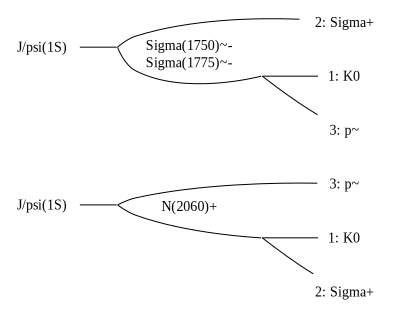

In [31]:
reaction = qrules.generate_transitions(
    initial_state=[("J/psi(1S)", [-1, +1])],
    final_state=["K0", "Sigma+", "p~"],
    allowed_interaction_types="strong",
    allowed_intermediate_particles=[
        "N(2060)",
        "Sigma(1750)",
        "Sigma(1775)",
    ],
    mass_conservation_factor=0,
    particle_db=PDG,
)
reaction = normalize_state_ids(reaction)
dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

### Define amplitude model

In [32]:
def formulate_breit_wigner_with_ff(
    chain: ThreeBodyDecayChain,
) -> tuple[sp.Expr, dict[sp.Symbol, float]]:
    s = _get_mandelstam_s(chain)
    parameter_defaults = {}
    production_ff, new_pars = _create_form_factor(s, chain.production_node)
    parameter_defaults.update(new_pars)
    decay_ff, new_pars = _create_form_factor(s, chain.decay_node)
    parameter_defaults.update(new_pars)
    breit_wigner, new_pars = _create_breit_wigner(s, chain.decay_node)
    parameter_defaults.update(new_pars)
    return (
        production_ff * decay_ff * breit_wigner,
        parameter_defaults,
    )


def _create_form_factor(
    s: sp.Symbol,
    isobar: IsobarNode,
) -> tuple[sp.Expr, dict[sp.Symbol, float]]:
    assert isobar.interaction is not None, "Need LS-couplings"
    inv_mass = _generate_mass_symbol(isobar.parent, s)
    outgoing_state_mass1 = _generate_mass_symbol(_get_particle(isobar.child1), s)
    outgoing_state_mass2 = _generate_mass_symbol(_get_particle(isobar.child2), s)
    meson_radius = _create_meson_radius_symbol(isobar.parent)
    form_factor = FormFactor(
        s=inv_mass**2,
        m1=outgoing_state_mass1,
        m2=outgoing_state_mass2,
        angular_momentum=isobar.interaction.L,
        meson_radius=meson_radius,
    )
    parameter_defaults = {
        meson_radius: 1,
    }
    return form_factor, parameter_defaults


def _generate_mass_symbol(state: State | Particle, s: sp.Symbol) -> sp.Symbol:
    if isinstance(state, State):
        return create_mass_symbol(state)
    return sp.sqrt(s)


def _create_breit_wigner(
    s: sp.Symbol,
    isobar: IsobarNode,
) -> tuple[sp.Expr, dict[sp.Symbol, float]]:
    assert isobar.interaction is not None, "Need LS-couplings"
    outgoing_state_mass1 = create_mass_symbol(isobar.child1)
    outgoing_state_mass2 = create_mass_symbol(isobar.child2)
    angular_momentum = isobar.interaction.L
    res_mass = create_mass_symbol(isobar.parent)
    res_width = sp.Symbol(Rf"\Gamma_{{{isobar.parent.latex}}}", nonnegative=True)
    meson_radius = _create_meson_radius_symbol(isobar.parent)

    breit_wigner_expr = RelativisticBreitWigner(
        s=s,
        mass0=res_mass,
        gamma0=res_width,
        m1=outgoing_state_mass1,
        m2=outgoing_state_mass2,
        angular_momentum=angular_momentum,
        meson_radius=meson_radius,
    )
    parameter_defaults = {
        res_mass: isobar.parent.mass,
        res_width: isobar.parent.width,
        meson_radius: 1,
    }
    return breit_wigner_expr, parameter_defaults


def _create_meson_radius_symbol(isobar: IsobarNode) -> sp.Symbol:
    particle = _get_particle(isobar)
    if isinstance(particle, State):
        if particle.index != 0:
            msg = "Only the initial state has a meson radius"
            raise NotImplementedError(msg)
        return sp.Symbol(R"R_{J/\psi}")
    return sp.Symbol(Rf"R_\mathrm{{{particle.latex}}}")


def create_mass_symbol(particle: IsobarNode | Particle) -> sp.Symbol:
    particle = _get_particle(particle)
    if isinstance(particle, State):
        return sp.Symbol(f"m{particle.index}", nonnegative=True)
    return sp.Symbol(f"m_{{{particle.latex}}}", nonnegative=True)


def _get_mandelstam_s(decay: ThreeBodyDecayChain) -> sp.Symbol:
    s1, s2, s3 = sp.symbols("sigma1:4", nonnegative=True)
    m1, m2, m3 = map(create_mass_symbol, decay.final_state)
    decay_masses = {create_mass_symbol(p) for p in decay.decay_products}
    if decay_masses == {m2, m3}:
        return s1
    if decay_masses == {m1, m3}:
        return s2
    if decay_masses == {m1, m2}:
        return s3
    msg = f"Cannot find Mandelstam variable for {''.join(decay_masses)}"
    raise NotImplementedError(msg)


def _get_particle(isobar: IsobarNode | State) -> State | Particle:
    if isinstance(isobar, IsobarNode):
        return isobar.parent
    return isobar

In [33]:
def prepare_for_phsp(model: AmplitudeModel) -> AmplitudeModel:
    p1, p2, p3 = (FourMomentumSymbol(f"p{i}", shape=[]) for i in (1, 2, 3))
    s1, s2, s3 = sp.symbols("sigma1:4", nonnegative=True)
    mass_definitions = {
        s1: InvariantMassSquared(p2 + p3),
        s2: InvariantMassSquared(p1 + p3),
        s3: InvariantMassSquared(p1 + p2),
        sp.Symbol("m0", nonnegative=True): InvariantMass(p1 + p2 + p3),
        sp.Symbol("m1", nonnegative=True): InvariantMass(p1),
        sp.Symbol("m2", nonnegative=True): InvariantMass(p2),
        sp.Symbol("m3", nonnegative=True): InvariantMass(p3),
    }
    mass_definitions = {k: sp.sympify(v) for k, v in mass_definitions.items()}
    angle_and_mandelstam_definitions = {
        symbol: expr.xreplace(mass_definitions)
        for symbol, expr in model.variables.items()
    }
    angle_and_mandelstam_definitions.update(mass_definitions)
    polarized_intensity = set_initial_state_polarization(
        model.intensity,
        spin_projections=(-1, +1),
    )
    new_parameter_defaults = {
        symbol: v
        for symbol, v in model.parameter_defaults.items()
        if not re.match(r"m[0-3]", symbol.name)
    }
    return attrs.evolve(
        model,
        intensity=polarized_intensity,
        variables=angle_and_mandelstam_definitions,
        parameter_defaults=new_parameter_defaults,
    )


def set_initial_state_polarization(
    intensity: PoolSum, spin_projections: Iterable[sp.Rational | float]
) -> PoolSum:
    helicity_symbol, _ = intensity.indices[0]
    helicity_values = tuple(sp.Rational(i) for i in spin_projections)
    new_indices = (
        (helicity_symbol, helicity_values),
        *intensity.indices[1:],
    )
    return PoolSum(intensity.expression, *new_indices)


@unevaluated
class InvariantMassSquared(sp.Expr):
    momentum: sp.Basic
    _latex_repr_ = R"M^2\left({momentum}\right)"

    def evaluate(self) -> sp.Expr:
        p = self.momentum
        p_xyz = ThreeMomentum(p)
        return Energy(p) ** 2 - EuclideanNorm(p_xyz) ** 2

In [34]:
decay = to_three_body_decay(reaction.transitions, min_ls=False)
builder = DalitzPlotDecompositionBuilder(decay, min_ls=False)
for chain in builder.decay.chains:
    builder.dynamics_choices.register_builder(chain, formulate_breit_wigner_with_ff)
model = builder.formulate(reference_subsystem=2, cleanup_summations=True)
model = prepare_for_phsp(model)
model.intensity.cleanup()

PoolSum(Abs(PoolSum(A^2[\lambda_0^{\prime}, 0, \lambda_2^{\prime}, \lambda_3^{\prime}]*WignerD(1/2, \lambda_2^{\prime}, lambda2, 0, \zeta^2_{2(2)}, 0)*WignerD(1/2, \lambda_3^{\prime}, lambda3, 0, \zeta^3_{2(2)}, 0)*WignerD(1, lambda0, \lambda_0^{\prime}, 0, \zeta^0_{2(2)}, 0) + A^3[\lambda_0^{\prime}, 0, \lambda_2^{\prime}, \lambda_3^{\prime}]*WignerD(1/2, \lambda_2^{\prime}, lambda2, 0, \zeta^2_{3(2)}, 0)*WignerD(1/2, \lambda_3^{\prime}, lambda3, 0, \zeta^3_{3(2)}, 0)*WignerD(1, lambda0, \lambda_0^{\prime}, 0, \zeta^0_{3(2)}, 0), (\lambda_0^{\prime}, (-1, 0, 1)), (\lambda_2^{\prime}, (-1/2, 1/2)), (\lambda_3^{\prime}, (-1/2, 1/2))))**2, (lambda0, (-1, 1)), (lambda2, (-1/2, 1/2)), (lambda3, (-1/2, 1/2)))

### Generate phase space sample

In [35]:
dpd_transformer = SympyDataTransformer.from_sympy(model.variables, backend="jax")

In [36]:
phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[0].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
rng = TFUniformRealNumberGenerator(seed=0)
phsp = phsp_generator.generate(100_000, rng)
phsp = dpd_transformer(phsp)
phsp = {k: phsp[k] for k in sorted(phsp)}
phsp = {k: v if jnp.iscomplex(v).any() else v.real for k, v in phsp.items()}

Generating phase space sample: 100%|████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 212864.64it/s]


In [37]:
phsp

{'\\zeta^0_{2(2)}': Array(0, dtype=int64, weak_type=True),
 '\\zeta^0_{3(2)}': Array([-2.53357417, -2.43246297, -2.75588118, ..., -1.62304026, -2.86346239, -2.82115694], dtype=float64),
 '\\zeta^2_{2(2)}': Array(0, dtype=int64, weak_type=True),
 '\\zeta^2_{3(2)}': Array([0.48645084, 0.58458208, 0.26202874, ..., 0.46663255, 0.17000109, 1.20388426], dtype=float64),
 '\\zeta^3_{2(2)}': Array(0, dtype=int64, weak_type=True),
 '\\zeta^3_{3(2)}': Array([0.78587981, 0.67615773, 1.17998783, ..., 0.55902986, 1.50696702, 0.22775613], dtype=float64),
 'm0': Array([3.0969, 3.0969, 3.0969, ..., 3.0969, 3.0969, 3.0969], dtype=float64),
 'm1': Array([0.497611, 0.497611, 0.497611, ..., 0.497611, 0.497611, 0.497611], dtype=float64),
 'm2': Array([1.18937, 1.18937, 1.18937, ..., 1.18937, 1.18937, 1.18937], dtype=float64),
 'm3': Array([0.93827209, 0.93827209, 0.93827209, ..., 0.93827209, 0.93827209, 0.93827209], dtype=float64),
 'sigma1': Array([5.9276109 , 5.8019359 , 6.08202612, ..., 4.94158867, 6.080

### Prepare numerical function

In [38]:
full_intensity_expr = cached.unfold(model)

In [39]:
fixed_parameters = {
    symbol: value
    for symbol, value in model.parameter_defaults.items()
    if "production" not in str(symbol)
}
full_intensity_expr = cached.xreplace(full_intensity_expr, fixed_parameters)

In [40]:
coupling_parameters = {
    symbol: value
    for symbol, value in model.parameter_defaults.items()
    if symbol not in fixed_parameters
}

In [41]:
intensity_func = cached.lambdify(
    full_intensity_expr,
    parameters=coupling_parameters,
    backend="jax",
)

## Compute acceptance matrix

#### Brute-force computation

In [42]:
def compute_intensity_matrix(
    func: ParametrizedFunction, phsp: DataSample, ci: complex, cj: complex
) -> np.ndarray:
    original_parameters = func.parameters.copy()
    coupling_parameters = [p for p in func.parameters if "production" in p]
    n = len(coupling_parameters)
    sub_intensity_matrix = np.zeros((n, n))
    for (i, c1), (j, c2) in itertools.product(
        enumerate(coupling_parameters),
        enumerate(coupling_parameters),
    ):
        new_parameters = dict.fromkeys(coupling_parameters, 0)
        if c1 == c2:
            new_parameters[c1] = 1
        else:
            new_parameters[c1] = ci
            new_parameters[c2] = cj
        func.update_parameters(new_parameters)
        sub_intensities = func(phsp)
        func.update_parameters(original_parameters)
        sub_intensity_matrix[i, j] = integrate_intensity(sub_intensities)
    return sub_intensity_matrix

In [43]:
def integrate_intensity(intensities: jnp.ndarray) -> float:
    flattened_intensities = intensities.flatten()
    non_nan_intensities = flattened_intensities[~jnp.isnan(flattened_intensities)]
    return float(jnp.sum(non_nan_intensities) / len(non_nan_intensities))

In [44]:
%%time
A_plus = compute_intensity_matrix(intensity_func, phsp, ci=1, cj=+1)
B_plus = compute_intensity_matrix(intensity_func, phsp, ci=1, cj=+1j)
A_minus = compute_intensity_matrix(intensity_func, phsp, ci=1, cj=-1)
B_minus = compute_intensity_matrix(intensity_func, phsp, ci=1, cj=-1j)

CPU times: user 2.78 s, sys: 65.5 ms, total: 2.85 s
Wall time: 412 ms


In [45]:
X_temp = (A_plus - A_minus) / 4 + 1j / 4 * (B_plus - B_minus)
diagonal = np.tril(A_plus) - np.tril(A_plus, k=-1)
X_brute_force = diagonal + np.tril(X_temp, k=-1) + np.triu(X_temp, k=1)
X_brute_force.round(7)

array([[ 9.19800e-04+0.0000e+00j,  1.86000e-05-1.7880e-04j,  0.00000e+00+0.0000e+00j,  5.00000e-07-1.8000e-06j],
       [ 1.86000e-05+1.7880e-04j,  1.95840e-03+0.0000e+00j,  0.00000e+00+0.0000e+00j, -8.14600e-04+3.1594e-03j],
       [ 0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j],
       [ 5.00000e-07+1.8000e-06j, -8.14600e-04-3.1594e-03j,  0.00000e+00+0.0000e+00j,  9.51321e-02+0.0000e+00j]])

In [46]:
np.testing.assert_almost_equal(X_brute_force, X_brute_force.T.conj())

#### Smarter computation

In [47]:
def compute_acceptance_matrix(
    intensity_func: ParametrizedFunction,
    phsp: DataSample,
) -> np.ndarray:
    a_matrix = compute_intensity_matrix_upper_triangle(intensity_func, phsp, ci=1, cj=1)
    b_matrix = compute_intensity_matrix_upper_triangle(
        intensity_func, phsp, ci=1j, cj=1
    )
    diagonal = compute_intensity_matrix_diagonal(intensity_func, phsp)
    x_matrix = np.zeros(a_matrix.shape, dtype=complex)
    for i, j in itertools.product(range(a_matrix.shape[0]), range(a_matrix.shape[1])):
        if i < j:
            x_matrix[j, i] = (
                a_matrix[i, j]
                + 1j * b_matrix[i, j]
                - (1 + 1j) * (diagonal[i] + diagonal[j])
            ) / 2
    conjugate_upper_triangle = x_matrix.conjugate().T
    x_matrix += np.diag(diagonal) + conjugate_upper_triangle
    return x_matrix


def compute_intensity_matrix_upper_triangle(
    func: ParametrizedFunction, phsp: DataSample, ci: complex, cj: complex
) -> np.ndarray:
    original_parameters = func.parameters.copy()
    coupling_parameters = [p for p in func.parameters if "production" in p]
    n = len(coupling_parameters)
    sub_intensity_matrix = np.zeros((n, n))
    for (i, c1), (j, c2) in itertools.product(
        enumerate(coupling_parameters),
        enumerate(coupling_parameters),
    ):
        if i >= j:
            continue
        new_parameters = dict.fromkeys(coupling_parameters, 0)
        new_parameters[c1] = ci
        new_parameters[c2] = cj

        func.update_parameters(new_parameters)
        sub_intensities = func(phsp)
        func.update_parameters(original_parameters)

        sub_intensity_matrix[i, j] = integrate_intensity(sub_intensities)

    return sub_intensity_matrix


def compute_intensity_matrix_diagonal(
    func: ParametrizedFunction, phsp: DataSample
) -> np.ndarray:
    original_parameters = func.parameters.copy()
    coupling_parameters = [p for p in func.parameters if "production" in p]
    n = len(coupling_parameters)
    sub_intensity_array = np.zeros(n)

    for i, c1 in enumerate(coupling_parameters):
        for j in range(i, n):
            c2 = coupling_parameters[j]
            new_parameters = dict.fromkeys(coupling_parameters, 0)
            if c1 == c2:
                new_parameters[c1] = 1
            else:
                continue

            func.update_parameters(new_parameters)
            sub_intensities = func(phsp)
            func.update_parameters(original_parameters)

            sub_intensity_array[i] = integrate_intensity(sub_intensities)

    return sub_intensity_array


In [48]:
%%time
X = compute_acceptance_matrix(intensity_func, phsp)

CPU times: user 711 ms, sys: 10.1 ms, total: 721 ms
Wall time: 105 ms


In [49]:
X.round(7)

array([[ 9.19800e-04+0.0000e+00j,  1.86000e-05-1.7880e-04j,  0.00000e+00+0.0000e+00j,  5.00000e-07-1.8000e-06j],
       [ 1.86000e-05+1.7880e-04j,  1.95840e-03+0.0000e+00j,  0.00000e+00+0.0000e+00j, -8.14600e-04+3.1594e-03j],
       [ 0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j,  0.00000e+00+0.0000e+00j],
       [ 5.00000e-07+1.8000e-06j, -8.14600e-04-3.1594e-03j,  0.00000e+00+0.0000e+00j,  9.51321e-02+0.0000e+00j]])

In [50]:
np.testing.assert_almost_equal(X, X.T.conj())
np.testing.assert_almost_equal(X, X_brute_force)

## Test bilinear form 
The the bilinear form with the acceptance matrix is to be used within for thge optimatzation of the coupling parameters $c_{ij}$. The bilinear form should lead to trhe same result when calculating the sub-intensity directly by Monte-Carlo integration. In the following this expected behaviour is tested for different $c$.

Result taking every element of $c$ as $2+1i$ or 0 \
**Direct integration:**

In [52]:
parameter_names = list(intensity_func.parameters)
n = len(parameter_names)
all_c = [np.array(c, dtype=complex) for c in product([0, -2+1j], repeat=n) if any(c)]

integration_results = []
for c in all_c:
    new_parameters = dict(zip(parameter_names, c, strict=True))
    intensity_func.update_parameters(new_parameters)
    intensity_value = integrate_intensity(intensity_func(phsp))
    integration_results.append((tuple(c.astype(complex)), intensity_value))

for c_tuple, value in integration_results:
    print(f"c = {c_tuple} : {value}")

c = (0j, 0j, 0j, (-2+1j)) : 0.47566059240154324
c = (0j, 0j, (-2+1j), 0j) : 0.0
c = (0j, 0j, (-2+1j), (-2+1j)) : 0.47566059240154324
c = (0j, (-2+1j), 0j, 0j) : 0.009791940106611881
c = (0j, (-2+1j), 0j, (-2+1j)) : 0.47730695795678885
c = (0j, (-2+1j), (-2+1j), 0j) : 0.009791940106611881
c = (0j, (-2+1j), (-2+1j), (-2+1j)) : 0.47730695795678885
c = ((-2+1j), 0j, 0j, 0j) : 0.004598829255514586
c = ((-2+1j), 0j, 0j, (-2+1j)) : 0.4802644031397207
c = ((-2+1j), 0j, (-2+1j), 0j) : 0.004598829255514586
c = ((-2+1j), 0j, (-2+1j), (-2+1j)) : 0.4802644031397207
c = ((-2+1j), (-2+1j), 0j, 0j) : 0.014576716058889274
c = ((-2+1j), (-2+1j), 0j, (-2+1j)) : 0.48209671539172916
c = ((-2+1j), (-2+1j), (-2+1j), 0j) : 0.014576716058889274
c = ((-2+1j), (-2+1j), (-2+1j), (-2+1j)) : 0.48209671539172916


**Bilinear form:**

In [65]:
bilinear_results = []
for c in all_c:
    c_dagger = c.conj().T
    result = c_dagger @ X @ c
    bilinear_results.append((tuple(c.astype(complex)), result))

for c_tuple, value in bilinear_results:
    print(f"c = {c_tuple} : {value}")

c = (0j, 0j, 0j, (-2+1j)) : (0.4756605924015433+0j)
c = (0j, 0j, (-2+1j), 0j) : 0j
c = (0j, 0j, (-2+1j), (-2+1j)) : (0.4756605924015433+0j)
c = (0j, (-2+1j), 0j, 0j) : (0.009791940106611883+0j)
c = (0j, (-2+1j), 0j, (-2+1j)) : (0.4773069579567889-2.7755575615628914e-17j)
c = (0j, (-2+1j), (-2+1j), 0j) : (0.009791940106611883+0j)
c = (0j, (-2+1j), (-2+1j), (-2+1j)) : (0.4773069579567889-2.7755575615628914e-17j)
c = ((-2+1j), 0j, 0j, 0j) : (0.004598829255514586+0j)
c = ((-2+1j), 0j, 0j, (-2+1j)) : (0.4802644031397208-2.7755575615628914e-17j)
c = ((-2+1j), 0j, (-2+1j), 0j) : (0.004598829255514586+0j)
c = ((-2+1j), 0j, (-2+1j), (-2+1j)) : (0.4802644031397208-2.7755575615628914e-17j)
c = ((-2+1j), (-2+1j), 0j, 0j) : (0.014576716058889268+0j)
c = ((-2+1j), (-2+1j), 0j, (-2+1j)) : (0.48209671539172927+0j)
c = ((-2+1j), (-2+1j), (-2+1j), 0j) : (0.014576716058889268+0j)
c = ((-2+1j), (-2+1j), (-2+1j), (-2+1j)) : (0.48209671539172927+0j)


**Difference:**

In [66]:
for (c, bilinear), (_, integration) in zip(
    bilinear_results, integration_results, strict=True
):
    print(f"{c} : {bilinear == integration!r:6s} {bilinear - integration}")

(0j, 0j, 0j, (-2+1j)) : False  (5.551115123125783e-17+0j)
(0j, 0j, (-2+1j), 0j) : True   0j
(0j, 0j, (-2+1j), (-2+1j)) : False  (5.551115123125783e-17+0j)
(0j, (-2+1j), 0j, 0j) : False  (1.734723475976807e-18+0j)
(0j, (-2+1j), 0j, (-2+1j)) : False  (5.551115123125783e-17-2.7755575615628914e-17j)
(0j, (-2+1j), (-2+1j), 0j) : False  (1.734723475976807e-18+0j)
(0j, (-2+1j), (-2+1j), (-2+1j)) : False  (5.551115123125783e-17-2.7755575615628914e-17j)
((-2+1j), 0j, 0j, 0j) : True   0j
((-2+1j), 0j, 0j, (-2+1j)) : False  (1.1102230246251565e-16-2.7755575615628914e-17j)
((-2+1j), 0j, (-2+1j), 0j) : True   0j
((-2+1j), 0j, (-2+1j), (-2+1j)) : False  (1.1102230246251565e-16-2.7755575615628914e-17j)
((-2+1j), (-2+1j), 0j, 0j) : False  (-5.204170427930421e-18+0j)
((-2+1j), (-2+1j), 0j, (-2+1j)) : False  (1.1102230246251565e-16+0j)
((-2+1j), (-2+1j), (-2+1j), 0j) : False  (-5.204170427930421e-18+0j)
((-2+1j), (-2+1j), (-2+1j), (-2+1j)) : False  (1.1102230246251565e-16+0j)


Now new values for the elements of $c$ are generated by variing the magnitude of the $c_i$ around one according the a log-normal distribution and the complex phase according to a uniform distrubution. **Note that this time each $c_i$ has a different phase and magnitude.**

In [67]:
n_tests = 2
rng = np.random.default_rng(seed=0)
for _ in range(n_tests):
    c_abs = rng.lognormal(mean=1, sigma=0.1, size=n)
    c_phase = rng.uniform(-np.pi, +np.pi, size=n)
    c = c_abs * np.exp(1j * c_phase)


    new_parameters = dict(zip(parameter_names, c, strict=True))
    intensity_func.update_parameters(new_parameters)

    intensity_value_original = (intensity_func(phsp))

    c_dagger = c.conj().T
    intensity_value_bilinear = c_dagger @ X @ c

    difference = intensity_value_bilinear - intensity_value_original
    display(f"Coupling vector:{c}")
    display(f"Difference of bilinear form and integration: {difference.round(40)}")

'Coupling vector:[-1.06569825+2.53801196j -2.28954735+1.39798407j  2.27154164+1.79968397j  0.35290261+2.72418355j]'

'Difference of bilinear form and integration: [ 0.23648689+0.j  0.00888089+0.j  0.45263134+0.j ... -0.48454498+0.j  0.51066115+0.j -0.37047465+0.j]'

'Coupling vector:[-1.58290193+1.97822173j -2.34204613-0.50169816j  0.3255897 +2.53319191j -1.22915563-2.43712076j]'

'Difference of bilinear form and integration: [ 0.18662545+0.j -0.01126296+0.j  0.30587783+0.j ... -0.67935309+0.j  0.29209441+0.j -0.65611383+0.j]'